<a href="https://colab.research.google.com/github/eapzz/mycode/blob/main/Project_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings



In [ ]:
import pandas as pd
train =  pd.read_json(r"C:\Users\lenovo\Downloads\events\events_England.json")
train

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [ ]:
shots = train.loc[train['subEventName'] == 'Shot']
#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

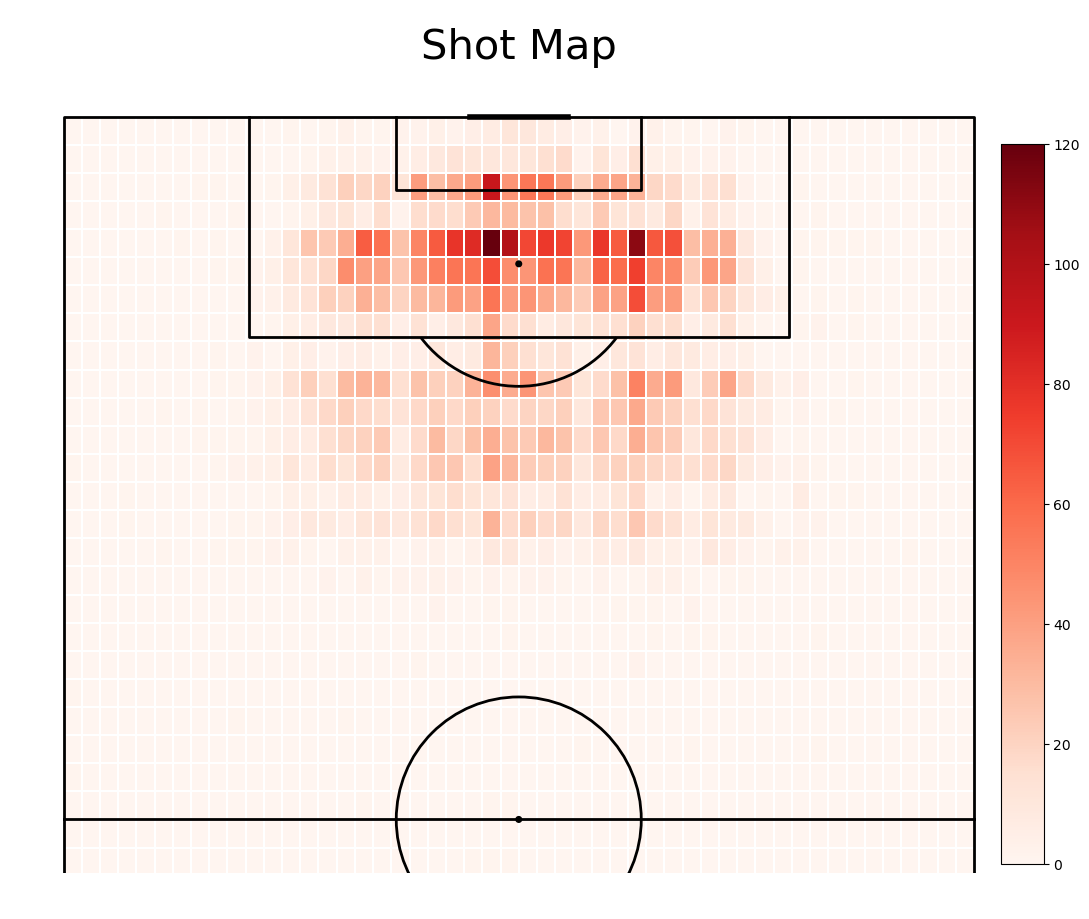

In [ ]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot Map' , fontsize = 30)
plt.show()

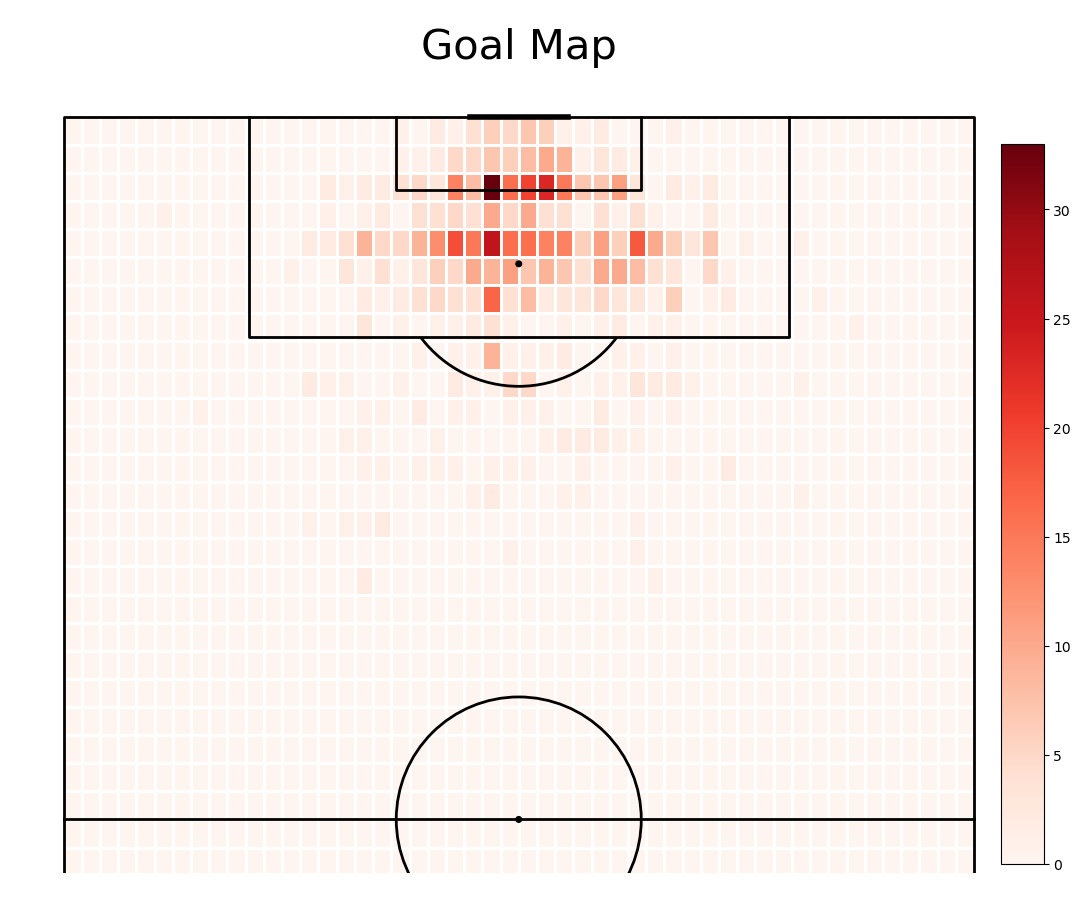

In [ ]:
# Filter only goal events
goals = shots.loc[shots["Goal"] == 1]

# Plot the football pitch
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

# Calculate the number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

# Plot the heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

# Add legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

# Add title and labels
fig.suptitle('Goal Map', fontsize=30)
# Show the plot
plt.show()


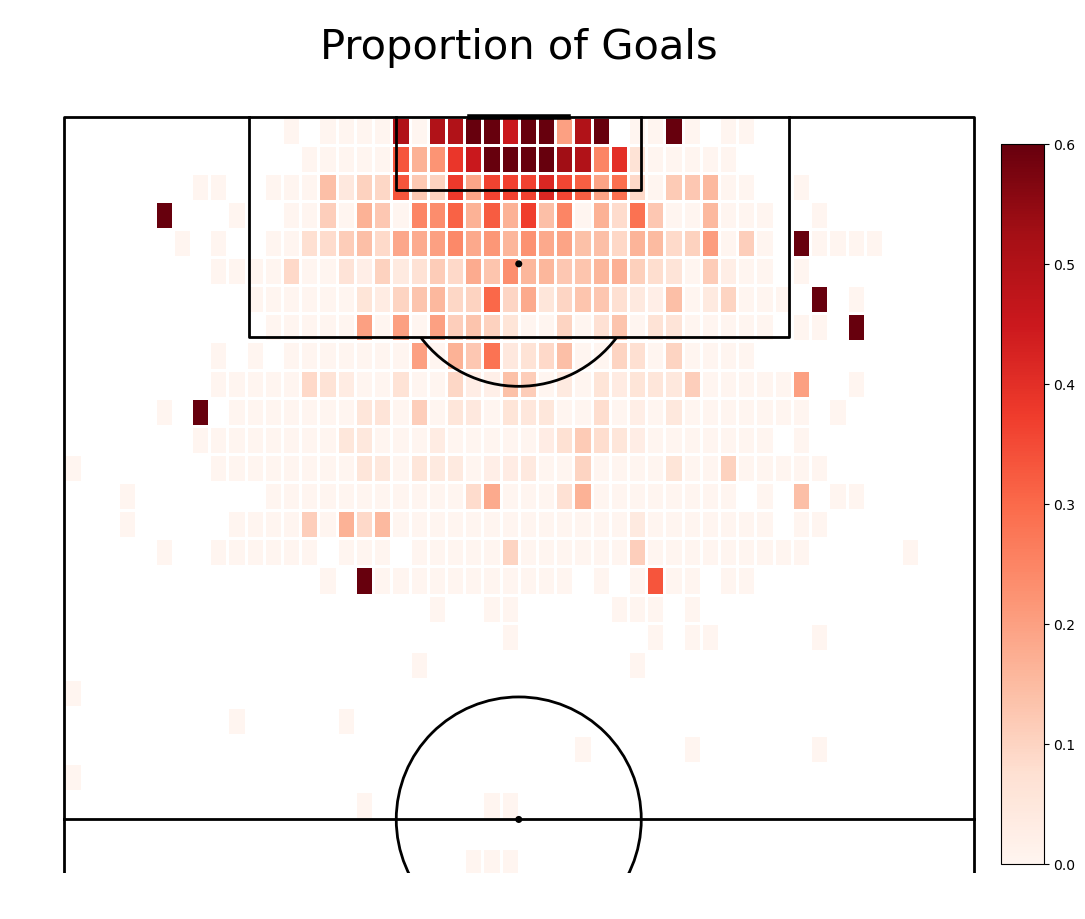

In [ ]:
# Plot the football pitch
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

# Calculate the number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# Normalize the number of goals by the number of shots
probability_statistic = bin_statistic_goals["statistic"] / bin_statistic_shots["statistic"]
bin_statistic_shots["statistic"] = probability_statistic

# Plot the heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin=0, vmax=0.6)

# Add legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

# Add title
fig.suptitle('Proportion of Goals', fontsize=30)

# Show the plot
plt.show()


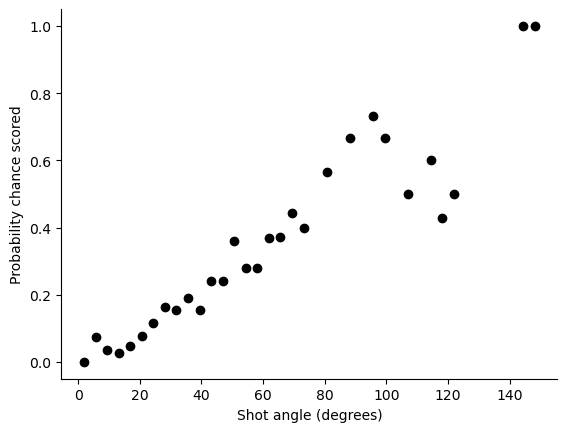

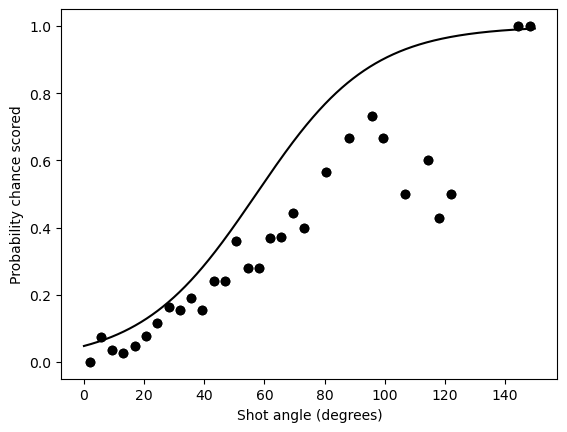

In [ ]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2537.7
Date:                    Sat, 18 Nov 2023   Deviance:                       5075.3
Time:                            17:15:29   Pearson chi2:                 8.14e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08122
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

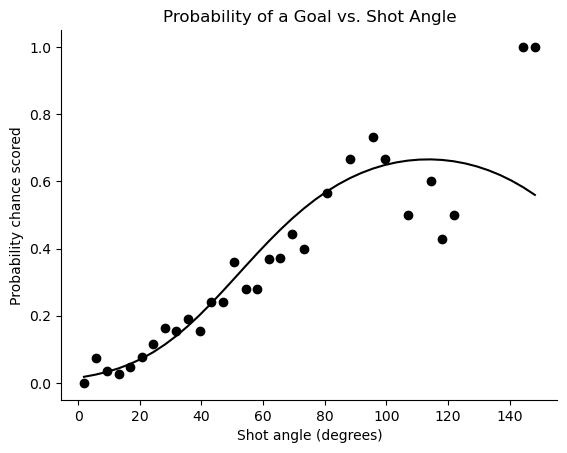

In [ ]:
# Create a squared angle feature
shots['Angle2'] = shots['Angle']**2
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
# Fit the GLM with the squared angle term
test_model = smf.glm(formula="Goal ~ Angle+Angle2", data=shots,
                       family=sm.families.Binomial()).fit()
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
# Print the model summary
print(test_model.summary())
midangle = (angle[:-1] + angle[1:])/2
# Extract the model parameters
b = test_model.params

# Calculate the expected goal (xG) probability
xGprob = 1 / (1 + np.exp(b[0] + b[1] * midangle * np.pi / 180 + b[2] * midangle**2 * np.pi**2 / 180**2))

# Create the plot
fig, ax = plt.subplots()

# Plot the data and the fitted line
ax.plot(midangle, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')

# Set labels and title
ax.set_ylabel('Probability chance scored')
ax.set_xlabel('Shot angle (degrees)')
ax.set_title('Probability of a Goal vs. Shot Angle')

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2524.4
Date:                    Sat, 18 Nov 2023   Deviance:                       5048.9
Time:                            17:15:30   Pearson chi2:                 1.56e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

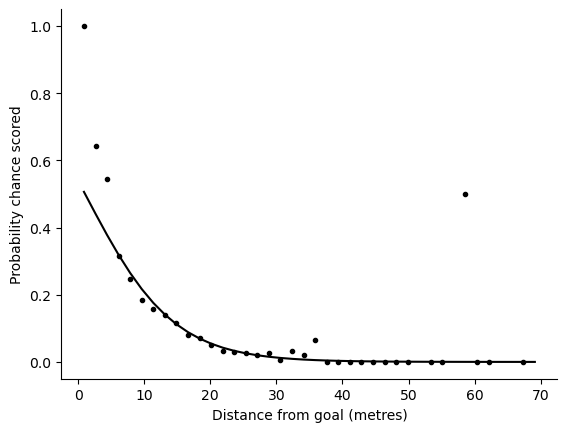

In [ ]:
#number of shots
shotcount_dist = np.histogram(shots['Distance'],bins=40,range=[0, 70])
#number of goals
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, 70])
#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance))
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2505.6
Date:                    Sat, 18 Nov 2023   Deviance:                       5011.1
Time:                            17:15:30   Pearson chi2:                 8.44e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

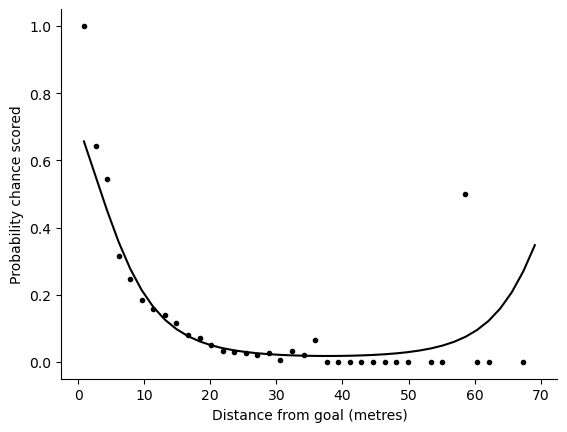

In [ ]:
#calculating distance squared
shots["D2"] = shots['Distance']**2
#adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots,
                           family=sm.families.Binomial()).fit()
#print model summary
print(test_model.summary())
#get parameters
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8446
Model Family:                    Binomial   Df Model:                            4
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2499.5
Date:                    Sat, 18 Nov 2023   Deviance:                       4999.0
Time:                            17:15:31   Pearson chi2:                 8.34e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08949
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

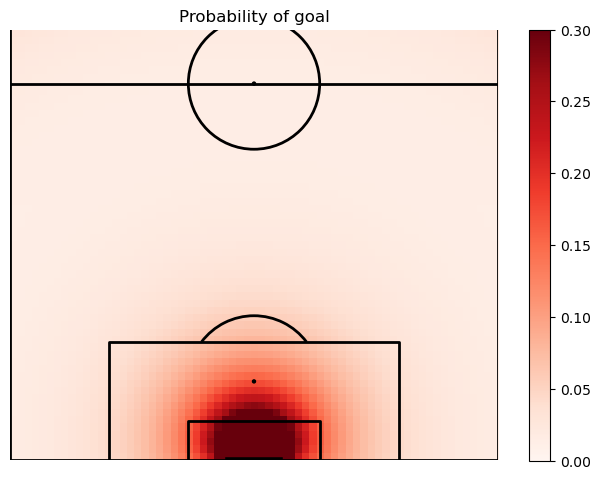

In [ ]:
#creating extra variables
shots["X_squared"] = shots['X']**2
shots["C_squared"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']
shots['Angle2'] = shots['Angle']**2
shots["D2"] = shots['Distance']**2
# list the model variables you want here
model_variables = ['Angle','Distance', 'Angle2', 'D2']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params

#return xG value for more general model
def calculate_xG(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#add an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1)
shots = shots.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Angle2'] = a**2
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X_squared'] = x**2

        sh['C_squared'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Mcfaddens Rsquared 0.1368054776995533


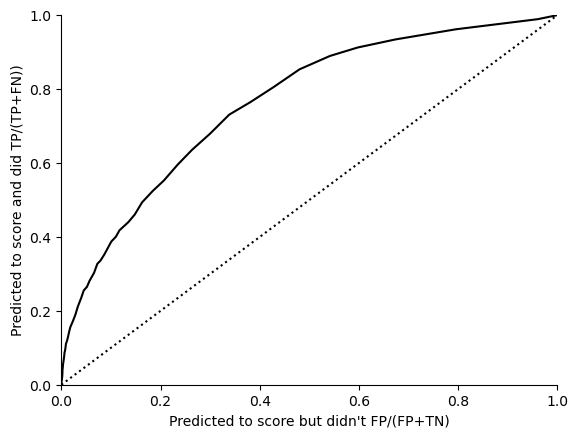

In [ ]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots,
                     family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)